In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.io import wavfile as wav
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.optimizers import Adam
from keras.utils import to_categorical


In [ ]:
df=pd.read_csv('urban_sound.csv')
labels=list(df['class'].unique())
files=dict()
for i in range(len(labels)):
  tmp=df[df['class']==labels[i]][:1].reset_index()
  path='/content/{}'.format(tmp['slice_file_name'][0])
  files[labels[i]]=path
  print(files)


FileNotFoundError: ignored

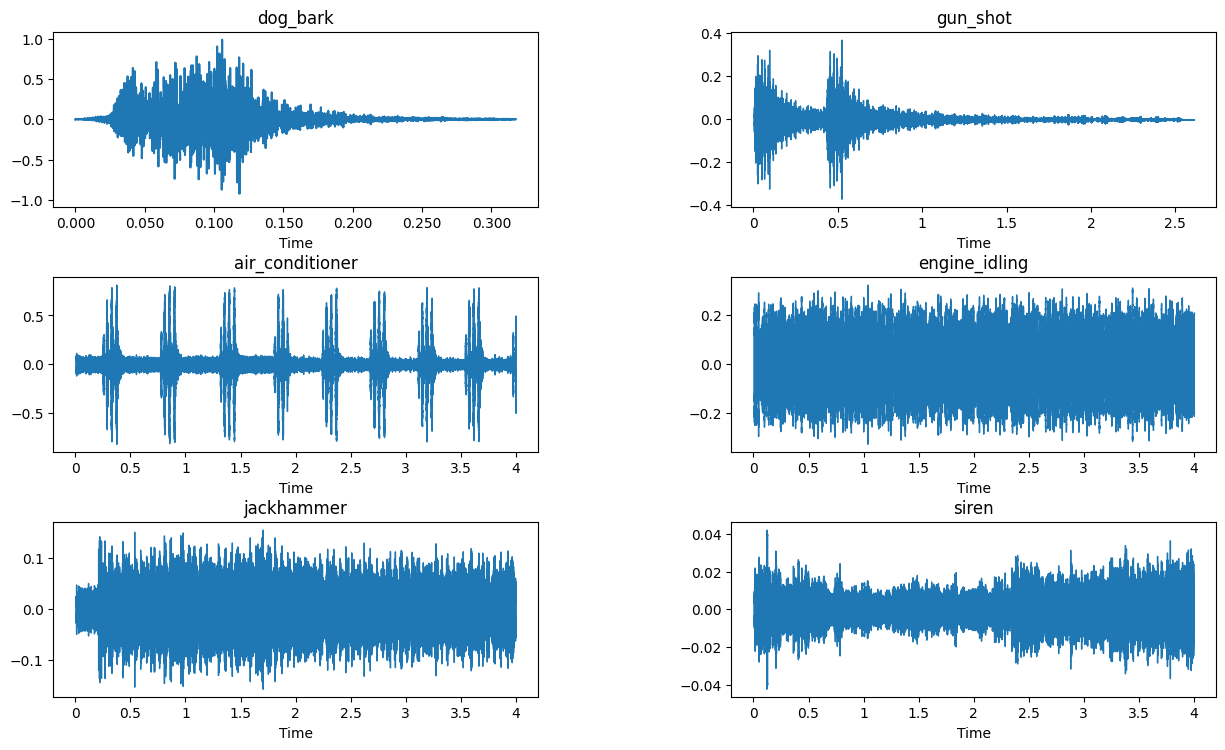

In [ ]:
fig=plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
for i,label in enumerate(labels):
  fn=files[label]
  fig.add_subplot(5,2,i+1)
  plt.title(label)
  data,sample_rate=librosa.load(fn)
  librosa.display.waveshow(data,sr=sample_rate)

In [ ]:
fn='/content/103074-7-1-5.wav'
librosa_audio,librosa_sample_rate=librosa.load(fn)
scipy_sample_rate,scipy_audio=wav.read(fn)
print("original sample rate: {}".format(scipy_sample_rate))
print("librosa sample rate: {}".format(librosa_sample_rate))

original sample rate: 48000
librosa sample rate: 22050


In [ ]:
print('original audio fiile min max range: {} to {}'.format(np.min(scipy_audio),np.max(scipy_audio)))
print('librosa audio fiile min max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio),np.max(librosa_audio)))

original audio fiile min max range: -436618752 to 369871360
librosa audio fiile min max range: -0.19 to -0.19


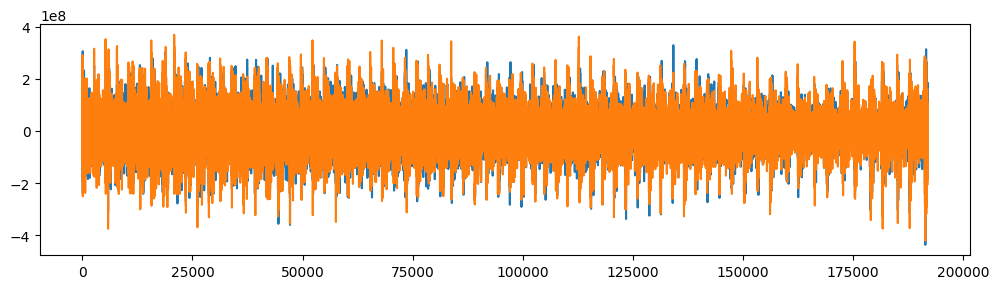

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')

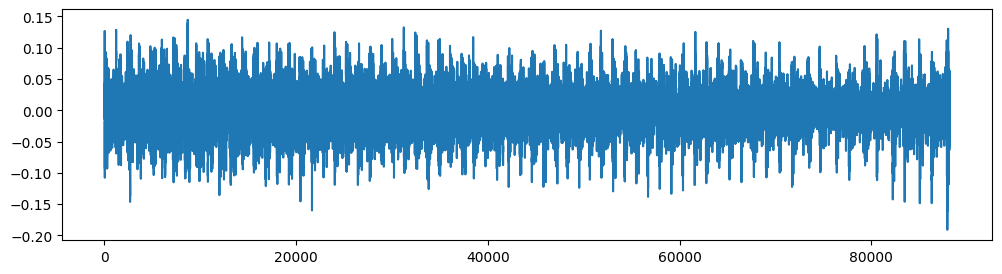

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')


In [ ]:
mfccs=librosa.feature.mfcc(y=librosa_audio,sr=librosa_sample_rate,n_mfcc=40)
print(mfccs)
print(mfccs.shape)

[[-170.2042    -154.65224   -157.97223   ... -192.12804   -173.58134
  -153.98914  ]
 [  61.22274     67.63315     69.52345   ...   90.14308     88.20128
    75.54779  ]
 [  -2.4723902  -11.398943     0.9684372 ...   12.501712    20.517513
    21.696466 ]
 ...
 [  -1.0027523   -0.4113003   -0.6741173 ...    1.1090817    5.1631575
     3.5969315]
 [  -4.010949    -3.4170666   -2.1557565 ...   -2.5016248   -2.8669806
    -8.111862 ]
 [  -2.4666266    1.3920166    6.5274043 ...    4.939772     1.5760292
    -1.4038985]]
(40, 173)


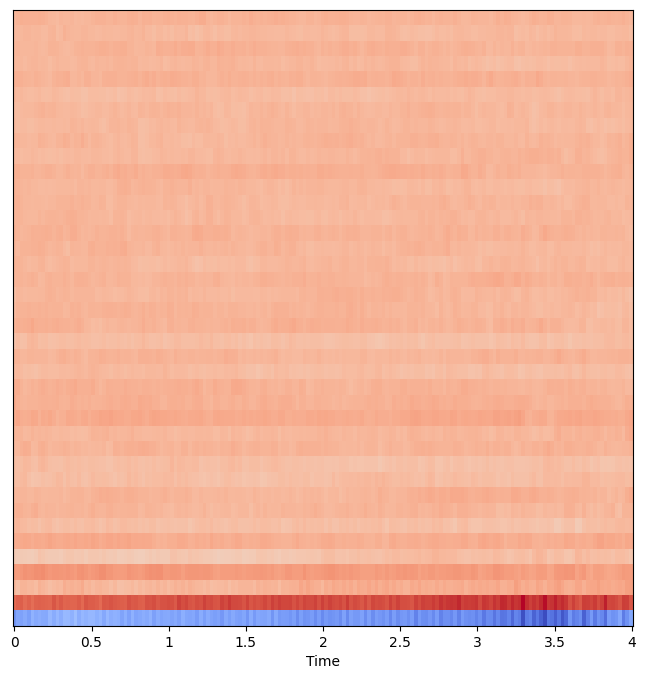

In [ ]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs,sr=librosa_sample_rate,x_axis='time')

model building


In [ ]:
def extract_features(file_path):
  audio,sample_rate= librosa.load(file_path)
  mfccs=librosa.feature.mfcc(y=librosa_audio,sr=librosa_sample_rate,n_mfcc=12)
  mfccs_scaled = np.mean(mfccs.T,axis=0)
  return mfccs_scaled

In [ ]:
metadata=pd.read_csv('/content/urban_sound.csv')

features=[]
labels=[]
for index,row in metadata.iterrows():
  file_path=row['slice_file_name']
  label=row['class']
  features.append(extract_features(file_path))
  labels.append(label)

features[0].shape


(12,)

In [ ]:
featuresdf=pd.DataFrame({'features':features,'labels':labels})

In [ ]:
featuresdf

,features,labels
0,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",dog_bark
1,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",dog_bark
2,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",dog_bark
3,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",dog_bark
4,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",dog_bark
...,...,...
146,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",siren
147,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",siren
148,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",siren
149,"[-166.87595, 81.59763, 4.9375863, 25.04207, -1...",siren


In [ ]:
x=np.array(featuresdf.features.tolist())
y=np.array(featuresdf.labels.tolist())
le=LabelEncoder()
ting=le.fit_transform(y)
yy=to_categorical(ting)


In [ ]:
original_labels=le.classes_
print("original labels:",original_labels)
print("encoded labels:",np.unique(ting))



original labels: ['air_conditioner' 'dog_bark' 'engine_idling' 'gun_shot' 'jackhammer'
 'siren']
encoded labels: [0 1 2 3 4 5]


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,yy,test_size=0.2,random_state=127)

In [ ]:
yy.shape

(151, 6)

In [ ]:
num_labels=yy.shape[1]
print(num_labels)

def build_model_graph(input_shape=(40,)):
  model=Sequential()
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_labels))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
  return model

model=build_model_graph()

6


In [ ]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs=100
num_batch_size=32
model.fit(x_train,y_train,batch_size=num_batch_size,epochs=num_epochs,validation_data=(x_test,y_test),verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 122ms/step - loss: 25.2112 - accuracy: 0.1667 - val_loss: 3.9894 - val_accuracy: 0.1613
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 20.6534 - accuracy: 0.1833 - val_loss: 6.1603 - val_accuracy: 0.2581
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 17.8848 - accuracy: 0.2167 - val_loss: 4.4596 - val_accuracy: 0.2258
Epoch 4/100
4/4 [==============================] - 0s 27ms/step - loss: 17.1208 - accuracy: 0.2167 - val_loss: 6.5364 - val_accuracy: 0.2258
Epoch 5/100
4/4 [==============================] - 0s 34ms/step - loss: 13.3987 - accuracy: 0.1833 - val_loss: 4.7328 - val_accuracy: 0.2258
Epoch 6/100
4/4 [==============================] - 0s 30ms/step - loss: 12.8209 - accuracy: 0.2500 - val_loss: 4.1534 - val_accuracy: 0.0968
Epoch 7/100
4/4 [==============================] - 0s 28ms/step - loss: 13.0547 - accuracy: 0.1667 - val_loss: 4.3927 - val_accuracy: 0.0968
Epoch 8/100


In [ ]:
score=model.evaluate(x_train,y_train,verbose=0)
print("testing accuracy: {0:.2%}".format(score[1]))

testing accuracy: 20.83%


In [ ]:
filename='/content/103074-7-1-6.wav'
prediction_feature=extract_features(filename)
prediction_feature=prediction_feature.reshape(1,-1)
model.predict(prediction_feature)

1/1 [==============================] - 0s 95ms/step


array([[0.20994072, 0.19689582, 0.19862762, 0.00035258, 0.20738187,
        0.18680143]], dtype=float32)

In [ ]:
predictions=model.predict(prediction_feature)
predicted_label=np.argmax(predictions)
print("predicted label:",{predicted_label})

1/1 [==============================] - 0s 22ms/step
predicted label: {0}
